# Documentation of Economic Analysis behind Simulation Engine

In this notebook we describe the logic behind the economic models and constructs that feed into the simulation engine of Emergent Alliance's _Regional Risk-Pulse Index_ project. This includes the construction of Leontief's inverse matrix used to quantify the input-ouput linkages between economic sectors and countries, some functions to shock Leontief's inverse, and a logic to understand how an economy would absorve and recover from a shock dynamically.

**Table of contents**
    
* [Constructing Leontief's Inverse](#Leontief)
    * [Input-output flows matrix Z](#Z)
    * [Final demands vector x](#x)
    * [Coefficients matrix A](#A)
    * [Leontief's inverse matrix L](#L)
* [Shock functions](#shock_functions)
    * [Shock total demand](#total_shock)
    * [Shock demand components](#components_shock)
    * [Function to shock anything](#shock_anything)
* [Dynamics of Shock response](#shock_dynamics)


<a id='Leontief'></a>
## 1. Constructing Leontief's Inverse

In this section we construct the Leontief inverse matrix using the worldwide IO tables provided by the [OECD](https://www.oecd.org/sti/ind/inter-country-input-output-tables.htm) [1]. We use the data for the last year available, 2015, which was published in 2018. To see how Leontief's inverse matrix is relevant, note that the $(i; j)$ element of the Leontief inverse, $l_{ij}$, measures the importance of industry $j$ as a direct and indirect input-supplier to industry $i$ in the economy. Furthermore, $l_{ij}$ accounts for all possible directed walks (of various lengths) that connect industry $j$ to industry $i$ over the network.

The process to construct the matrix is as follows: 
- First, we take the matrix of trade flows between sectors (the raw table that we get from the OECD), which we call Z, and aggregate all non-essential sectors. 
- Second, we construct the column vector x, which represents the total production by sector. 
- Third, we combine x and Z to get matrix A, which gives us the coefficients IO table. The difference between A and Z is that Z represents trade flows, whereas A represents the input linkages in terms of relative proportions (assuming a Cobb-Douglas production function). 
- Finally, we construct the Leontief inverse L from A. The Leontief inverse is defined as $L = (I-A)^{-1}$.

We will use a package called `pymrio` to ingest and process the OECD's input-output tables. You can read the docs [here](https://pymrio.readthedocs.io/en/latest/).

To know more about these matrices, their meaning, the Leontief model and how it is used in general, this [paper](http://vasco-m-carvalho.github.io/pdfs/ProductionNetworks.pdf) by Carvalho and Tahbaz-Salehi (2018) is a good reference. The notation for A and L is the same. Z is referred to as trade flows matrix. x is not explicitly mentioned.

In [1]:
# Imports and path
import warnings
try:
    import pymrio
except:
    warnings.warn('Pymrio missing')
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sbs

import random
from scipy.integrate import odeint

%matplotlib inline
oecd_storage = Path('/project_data/data_asset')

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Pymrio missing


In [3]:
# Select the year to parse - 2015 in this case
oecd_path_year = pymrio.parse_oecd(path=oecd_storage, year=2015)

<a id='Z'></a>
### 1.1. Input-Output flows matrix Z
Firs, we read the OECD tables and format them to get the matrix representing the direct relations between the sectors. We'll call this matrix Z. There are some non-essential sectors that we are not interested in, so we aggregate them under the label `All non-essential`. A sector has been classified as non-essential in line with the Italian government's [decree](http://www.governo.it/sites/new.governo.it/files/dpcm_20200322.pdf) from the 22nd of March.

In [ ]:
countries = oecd_path_year.get_regions()
non_essential_sectors = ['07T08','24','25','29','30','68']

In [ ]:
# Get Input-Output table
Z = oecd_path_year.Z.copy()
Z.shape

In [ ]:
# Collapse non-essential columns
country_NE = pd.DataFrame()

for country in countries:
    
    for sector in non_essential_sectors:
        
        column = Z[(country, sector)]
        country_NE = pd.concat([country_NE, column], axis = 1)
        Z.drop(columns = (country, sector), inplace = True)
    
    country_NE = country_NE.sum(axis = 1)
    
    Z[(country, 'All non-essential')] = country_NE
    
    country_NE = pd.DataFrame()

In [ ]:
# Collapse non-essential rows
country_NE = pd.DataFrame()

for country in countries:
    
    for sector in non_essential_sectors:
        
        row = Z.loc[(country, sector),:]
        country_NE = pd.concat([country_NE, row], axis = 1)
        Z.drop(index = (country, sector), inplace = True)
    
    country_NE = country_NE.sum(axis = 1)
    
    Z.loc[(country, 'All non-essential'),:] = country_NE
    
    country_NE = pd.DataFrame()

Z

<a id='x'></a>
### 1.2. Final demands vector x
The package pymrio has a method to construct x. It needs the industries' final demands, Y, as well as Z. We need to collapse the final demand from non-essential sectors before combining Z and Y.

In [ ]:
Y =  oecd_path_year.Y.copy()
Y.shape

In [ ]:
# Collapse non-essential rows
country_NE = pd.DataFrame()

for country in countries:
    
    for sector in non_essential_sectors:
        
        row = Y.loc[(country, sector),:]
        country_NE = pd.concat([country_NE, row], axis = 1)
        Y.drop(index = (country, sector), inplace = True)
    
    country_NE = country_NE.sum(axis = 1)
    
    Y.loc[(country, 'All non-essential'),:] = country_NE
    
    country_NE = pd.DataFrame()
    
Y

We can now combine matrices Z and Y to produce the total outputs vector x. We simply need to call pymrio's method `calc_x`.

In [ ]:
x = pymrio.calc_x(Z, Y)
x

<a id='A'></a>
### 1.3. Coefficients matrix A
Once we have x and Z, we can move on to calculate A.

In [ ]:
A = pymrio.calc_A(Z, x)
A

<a id='L'></a>
### 1.4. Leontief's inverse matrix L

Finally, having A we can derive the Leontief inverse matrix. 

In [ ]:
L = pymrio.calc_L(A)
L

In [ ]:
# Let's have a look at one country only
L.iloc[L.index.get_level_values('region') == 'DEU',
       L.columns.get_level_values('region') == 'DEU']

The matrices are now ready to be exported and used elsewhere. We will continue using these in this notebook to illustrate the other pieces of work.

In [ ]:
# Export to CSV
# L.to_csv('/project_data/data_asset/Leontief_inverse_world.csv')
# Y.to_csv('/project_data/data_asset/Leontief_final_demand_Y_world.csv')
# x.to_csv('/project_data/data_asset/Leontief_total_output_x_world.csv')
# A.to_csv('/project_data/data_asset/Leontief_coeff_A_world.csv')

<a id='shock_functions'></a>
## 2. Shock functions
We want to measure what happens when parts of the economy shut down. To do so, we need to model how we "switch off" a sector from the matrix (partially or totally). This is what the functions in this senction do. Ideally, the goal is to use them with the EMA workbench to produce multiple "what-if" scenarios through Monte Carlo simulation.

To do so, we are going to propagate a change in the production of one sector throughout the rest of the network (either upstream or downstream) using the Leontief inverse matrix. The way we will shock a sector is by shocking its final output vector, which we have called x. This will give us a vector of shocks whose entries will be the first-order change in output of all sectors (i.e. zero in all but for the shocked sector). We will then take the dot product of the Leontief inverse and the shocks vector, which will give us all the direct and indirect changes in all sectors. Finally, we'll add it to the original outputs vector, getting the new "state of the world" after the shock.

The functions come in two flavours: the first function shocks the total demand for a sector (i.e. it answers the question "what happens when one sector reduces production by $\Delta\%$" and is simpler to work with); the second is a bit more granular, and takes into account the fact that the final demand (matrix Y) has different components (think of households' consumption, public consumption, etc.). Hence, the second function allows us to shock specific components separately (i.e. it can answer the question "what happens when the government reduces its consumption from sector X by $\Delta\%$"). The third function wraps the first two. Since it makes it a bit more complex, we present the three functions as separate pieces; that way the end user can decide which one to use in their simulations.

All three functions can take two different types of shocks: supply-side and demand-side. The difference between a supply-side and a demand-side shock is the direction of the propagation of the shock: supply side shocks are upstream or, in other words, they come from further up the supply chain that feeds into the shocked sector. On the other hand, demand-side shocks have an impact downstream, meaning that they come from the sectors that consume the shocked sector's output.

<a id='total_shock'></a>
### 2.1. Shock total demand

In [ ]:
def shock_demand(L, x, country, sector, shock = -0.5, downstream = False):
    
    '''
    This function transmits a shock to one sector of a country's economy throught a network of sectors and countries 
    using their input-output linkages as defined by a Leontief inverse matrix L.
    
    Arguments:
    - L: Leontief inverse matrix. Entry (i, j) summarises all direct and indirect connections between (country, sector) i and 
    (country, sector) j. Dimensions must be (N x N), N being the number of country-sector combinations.
    - x: column vector with total outputs by country and sector. Dimesions must be (N x 1).
    - country: part of multiindex of L and x. The country of the sector that will be shocked.
    - sector: part of multiindex of L and x. The sector to be shocked.
    - shock: relative change in the output of a sector. By default, it's -0.5, i.e. a 50% decrease in output.
    - downstream: whether we want to propagate the shock upstream (supply shock) or downstream (demand shock). Default is False, i.e. upstream shock
    '''
    
    # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
    shock_vector = pd.DataFrame(np.zeros(x.shape), index = x.index, columns = ['delta'])
    shock_vector.loc[(country, sector)] = shock
    
    # Compute changes in (country, sector) X 
    x_prime = x.copy()
    x_prime['indout'] = shock_vector['delta'] * x['indout']
    
    # Compute the inner product of X' and Leontief inverse to get all changes
    if downstream == True:
        L = np.transpose(L) # By transposing the leontief inverse, we get the effect of the shock on the sectors downstream of the shocked sector
    
    output_change = x.copy()
    output_change['indout'] = np.dot(L, x_prime)
    
    # New X is original X plus changes
    new_output = x.copy()
    new_output = x + output_change
    new_output[new_output['indout'] < 0] = 0 # output can't be negative, 0 at most
    
    return new_output

In [ ]:
# Test on sector 01T03 in Argentina 
## Shock matrix
x_new = shock_demand(L, x, country = 'ARG', sector = '01T03', shock = -0.9)
x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
x_new

<a id='components_shock'></a>
### 2.2. Shock separate components of final demand

In [ ]:
def shock_demand_components(L, Z, Y, x, country, sector, demand_component, shock = -0.5, downstream = False):

    '''
    This function transmits a shock to a component of the demand for one sector of a country's economy throught a network of 
    sectors and countries using their input-output linkages as defined by a Leontief inverse matrix L.
    
    Arguments:
    - L: Leontief inverse matrix. Entry (i, j) summarises all direct and indirect connections between (country, sector) i and 
    (country, sector) j. Dimensions must be (N x N), N being the number of country-sector combinations.
    - Z: Input-Output matrix of output flows between sectors. Dimensions must be (N x N).
    - Y: Aggregate demand by sector. Dimensions must be (N x M), M being the number of country-demand components combinations.
    - x: column vector with total outputs by country and sector. Dimesions must be (N x 1).
    - country: part of multiindex of L and x. The country of the sector that will be shocked.
    - sector: part of multiindex of L and x. The sector to be shocked.
    - demand_component: component of sector's aggregate demand to be shocked. Possible values are:
        - 'HFCE'
        - 'NPISH'
        - 'GGFC'
        - 'GFCF'
        - 'INVNT'
        - 'P33'
    - shock: relative change in the output of a sector. By default, it's -0.5, i.e. a 50% decrease in demand.
    - downstream: whether we want to propagate the shock upstream (supply shock) or downstream (demand shock). Default is False, i.e. upstream shock
    '''
        
    # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
    shock_matrix = pd.DataFrame(np.zeros(Y.shape), index = Y.index, columns = Y.columns)
    shock_matrix.loc[(country, sector), (country, demand_component)] = shock
    
    # Compute changes in Y 
    Y_prime = Y.copy()
    Y_prime = Y_prime.multiply(shock_matrix)
    
    Z_prime = pd.DataFrame(np.zeros(Z.shape), index = Z.index, columns = Z.columns) # Pseudo-Z matrix will all zeros (as nothing changes in Z)
    
    x_prime = pymrio.calc_x(Z_prime, Y_prime) # Collapse Y_prime to get a column vector of the shape of x
    
    # Compute the inner product of X' and Leontief inverse to get all changes
    if downstream == True:
        L = np.transpose(L) # By transposing the leontief inverse, we get the effect of the shock on the sectors downstream of the shocked sector
    
    output_change = x.copy()
    output_change['indout'] = np.dot(L, x_prime)
    
    # New X is original X plus changes
    new_output = x.copy()
    new_output = x + output_change
    new_output[new_output['indout'] < 0] = 0 # output can't be negative, 0 at most

    return new_output


In [ ]:
# Test on household's (HFCE) demand for sector 01T03 in Argentina 
x_new = shock_demand_components(L, Z, Y, x, country = 'ARG', sector = '01T03', demand_component = 'HFCE', shock = -0.9)
x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
round(x_new.head(30), 3)

<a id='shock_anything'></a>
### 2.3. Function to shock anything

In [ ]:
def shock_anything(L, x, Z = None, Y = None, split_demand = False, 
                    country = None, sector = None, demand_component = None, 
                    shock = -0.5, downstream = False):

    '''
    This function transmits a shock to the demand for one sector of a country's economy through a network of sectors and countries using their 
    input-output linkages as defined by a Leontief inverse matrix L. The shock can be to the whole aggregate demand or to a particular component 
    (see below), depending on the value of split_demand.
    
    Arguments:
    - L: Leontief inverse matrix. Entry (i, j) summarises all direct and indirect connections between (country, sector) i and 
    (country, sector) j. Dimensions must be (N x N), N being the number of country-sector combinations.
    - x: column vector with total outputs by country and sector. Dimesions must be (N x 1).
    - Z: Input-Output matrix of output flows between sectors. Dimensions must be (N x N). Only applies when split_demand = True, so by default Z = None.
    - Y: Aggregate demand by sector. Dimensions must be (N x M), M being the number of country-demand components combinations. Only applies when split_demand = True, so by default Y = None.
    - split_demand: Boolean. Indicate if the shock is to the whole demand or just a part of it.
    - country: part of multiindex of L and x. The country of the sector that will be shocked.
    - sector: part of multiindex of L and x. The sector to be shocked.
    - demand_component: component of sector's aggregate demand to be shocked. Possible values are:
        - 'HFCE'
        - 'NPISH'
        - 'GGFC'
        - 'GFCF'
        - 'INVNT'
        - 'P33'
    - shock: relative change in the output of a sector. By default, it's -0.5, i.e. a 50% decrease in demand.
    - downstream: whether we want to propagate the shock upstream (supply shock) or downstream (demand shock). Default is False, i.e. upstream shock
    '''
    
    if (split_demand == False) & (country != None)  & (sector != None):
        
        # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
        shock_vector = pd.DataFrame(np.zeros(x.shape), index = x.index, columns = ['delta'])
        shock_vector.loc[(country, sector)] = shock

        # Compute changes in (country, sector) X 
        x_prime = x.copy()
        x_prime['indout'] = shock_vector['delta'] * x['indout']

    
    elif (split_demand == True) & (country != None)  & (sector != None)  & (demand_component != None):
        
        # Construct a shocks vector with all zeros but for the (country, sector) entry that we want to shock
        shock_matrix = pd.DataFrame(np.zeros(Y.shape), index = Y.index, columns = Y.columns)
        shock_matrix.loc[(country, sector), (country, demand_component)] = shock

        # Compute changes in Y 
        Y_prime = Y.copy()
        Y_prime = Y_prime.multiply(shock_matrix)

        Z_prime = pd.DataFrame(np.zeros(Z.shape), index = Z.index, columns = Z.columns) # Pseudo-Z matrix will all zeros (as nothing changes in Z)

        x_prime = pymrio.calc_x(Z_prime, Y_prime) # Collapse Y_prime to get a column vector of the shape of x
    
    
    # Compute the inner product of X' and Leontief inverse to get all changes
    if downstream == True:
        L = np.transpose(L) # By transposing the leontief inverse, we get the effect of the shock on the sectors downstream of the shocked sector
    
    output_change = x.copy()
    output_change['indout'] = np.dot(L, x_prime)
    
    # New X is original X plus changes
    new_output = x.copy()
    new_output = x + output_change
    new_output[new_output['indout'] < 0] = 0 + np.random.uniform(0, 0.01) # output can't be negative, 0 at most plus a small number for simulation

    return new_output

In [ ]:
# Test on household's (HFCE) demand for sector 01T03 in Argentina - split_demand = False (implicit as it's the default value)
x_new = shock_anything(L, x, Z, Y, country = 'ARG', sector = '01T03', demand_component = 'HFCE', shock = -0.9)

x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
round(x_new.head(10), 3)

In [ ]:
# Test on household's (HFCE) demand for sector 01T03 in Argentina - split_demand = True
x_new = shock_anything(L, x, Z, Y, split_demand = True, country = 'ARG', sector = '01T03', demand_component = 'HFCE', shock = -0.9)

x_new['before'] = x['indout']
x_new['Relative change, %'] = 100 * (x_new['indout'] - x_new['before'])/ x_new['before']
round(x_new.head(10), 3)

<a id='shock_dynamics'></a>
## 3. Static vs Dynamic shock response

In this section, we consider a dynamical system approach to analyze economic network response to demand shocks. Initially, an economy in a steady state is perturbed by means of an impulse shock. In a static view, where one assumes the output of economy will immediately adjust itself to the shock, will be contrasted with a dynamical system approach, especially in view of output behaviour with respect to time

A simple class definition of economic network with Leontief matrix with functions to produce impulse shock on country, sector and function to compute output given the demand.

In [2]:
class LeonTradeModel:
    
    def __init__(self,df_L,demand='unit'):
        self.df_L = df_L
        self.country_indices, self.sector_indices = df_L.index.get_level_values(0).values, df_L.index.get_level_values(1).values
        self.countries, self.sectors = df_L.index.get_level_values(0).unique().values, df_L.index.get_level_values(1).unique().values
        self.A = np.linalg.inv(self.df_L.values)
        if (demand == 'unit'):
            self.d_base = np.ones(len(df_L))
        else:
            self.d_base = demand
        self.x_base = np.dot(self.df_L.values,self.d_base)
        self.x_out = self.x_base
        
        
    def shock_impulse(self,shock_val,tsteps=30,country_code=None,sector_code=None):
        shock_vec = np.zeros(len(self.d_base))
        if (sector_code is not None) & (country_code is not None):
            #print(self.countries)
            #print(np.where(self.countries==country_code)[0])
            shocked_val_idx = (np.where(self.countries==country_code)[0][0] * len(set(self.sectors))) + np.where(self.sectors==sector_code)[0][0]
            
        elif (sector_code is None) & (country_code is not None):
            shocked_val_idx = np.where(self.country_indices==country_code)[0]
            
        elif (country_code is None) & (sector_code is not None):
            shocked_val_idx = np.where(self.sector_indices==sector_code)[0]
        
        shock_vec[shocked_val_idx] = shock_val
            
        
        
        return shock_vec
         
        
    
        
    def propagate_shock(self,shock_vec,inertia = 0,type='demand'):
        # Inertia models the time taken by the real economy to readjust.
        if type == 'demand':
            self.x_out = inertia*self.x_out + (1-inertia)*np.dot(self.df_L,demand_vec)
        else:
            self.x_out = inertia*self.x_out + (1-inertia)*np.dot(self.df_L.T,shock_vec)
            
        self.dem_out = demand_vec
        return self.x_out

Initialize a Economic network object with the actual Leontief matrix

In [3]:
# Read the L matrix and construct a dataframe with 2 indices country and sector
# df_lev = pd.read_csv('/project_data/data_asset/Leontief_inverse_world.csv',low_memory=False,index_col=[0,1],skiprows=[0,1])
df_lev = L
# Remap the column names
df_lev.columns = df_lev.index.get_level_values(1).values

network_model = LeonTradeModel(df_lev) 

Supply now a impulse shock at time=0 to say Sector 28 in Germany (DEU) and see the effect on same Sector 28 in the USA

In [4]:
shock_vec = network_model.shock_impulse(shock_val=0.01,country_code='DEU',sector_code='28')
demand_vec = shock_vec#network_model.d_base-shock_vec
x_out = network_model.propagate_shock(demand_vec)
out_change = x_out#(network_model.x_base-x_out)/network_model.x_base

print('Shock to Sector 28 in the US %s'%(out_change[1873]))
print('Overall output contraction %s'%(sum(out_change)))

Shock to Sector 28 in the US 2.2414136270656123e-06
Overall output contraction 0.01591377157759055


Visualize how the shock to Sector 28 in Germany affects other sectors in the same country

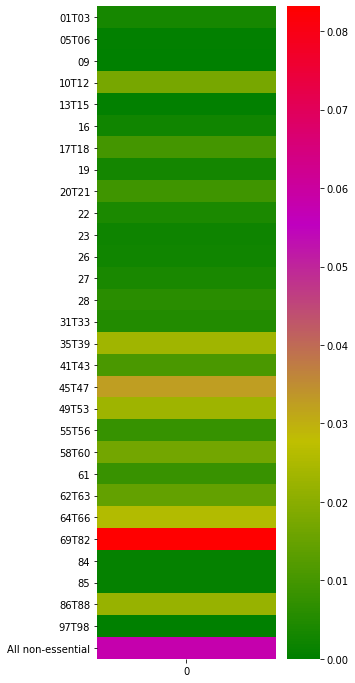

In [5]:
german_sector_indices = np.where(network_model.country_indices=='DEU')[0]

#german_sector_indices = german_sector_indices[german_sector_indices!=28]
response_shock_vals = (out_change[german_sector_indices])/max(shock_vec)
response_sector_mask = response_shock_vals<1


plt.figure(figsize=(4,12))

from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('gymr',["g", "y","m", "r"], N=256) 

ax = sbs.heatmap((response_shock_vals[response_sector_mask]).reshape(-1,1),annot=False,ax=None,cmap=cmap)
ax.set_yticklabels(network_model.sectors[response_sector_mask],rotation=0);

Essentially, the number above says that an impulse 0.01 Demand shock to Sector 28 in Germany at time t=0 causes a shock of 2.2e-6 units in the same sector in the US at that instant and an overall contraction in the economic output of the world by 0.016 units 

Let us now make the shock response a bit more dynamic now. Following the work from Klimek et. al., (https://www.nature.com/articles/s41467-019-09357-w.pdf), we model the output dynamics by a simple ODE of order 1, 

$Y_{dot} = (A-I)* Y  + D$, 

where Y, Y_dot, A,I and D denote output, vector differential of the output, I/O matrix, Identity matrix of the corresponding shape and Demand vector respectively.

A useful technique now is to characterize the system response by perturbing the system by applying an impulse. Unlike mathematical impulses which have infinite height and zero width, in the scope of this analysis the impulse is modelled as a finite pulse of a certain height and duration.

For ease of analysis, it is assumed that the shock pulse starts at time 0 and ends at time step 1. Use standard numerical integration to solve for system response

In [6]:
def economic_dynamics_ode(y,t,A,D,step_width=1):
    if (t < step_width):
        d = D
    else:
        d = np.zeros(len(D))
    
    return np.dot(A-np.eye(A.shape[0]),y) + d

sol = odeint(economic_dynamics_ode, np.zeros(len(network_model.df_L)), np.linspace(0,10,10), args=(-network_model.A,shock_vec))

Let us now look at time evolution of sector 28 in the US.

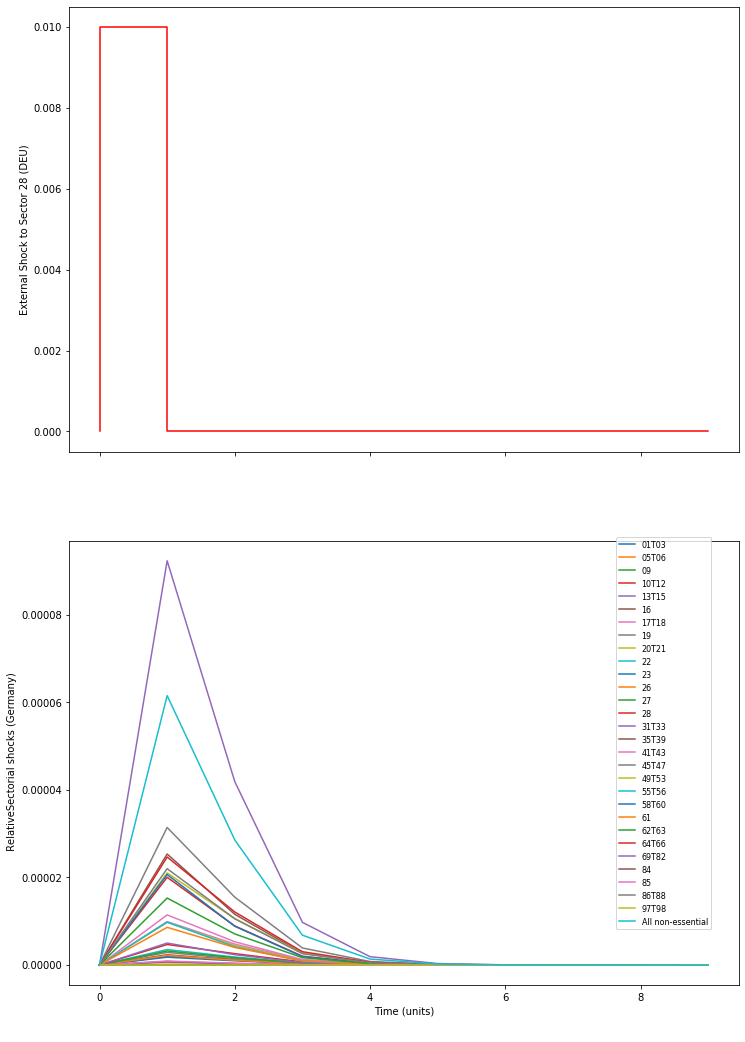

In [13]:
fig,axs=plt.subplots(2,1,figsize=(12,18),sharex=True)


axs[0].step(range(10),np.array([0,0.01,0,0,0,0,0,0,0,0]),'r')
axs[0].set_ylabel('External Shock to Sector 28 (DEU)');
axs[1].plot(range(10),sol[:,german_sector_indices[response_sector_mask]],'-');
axs[1].set_xlabel('Time (units)');
axs[1].set_ylabel(' RelativeSectorial shocks (Germany)');
leg = axs[1].legend(network_model.sectors[response_sector_mask],prop={'size':8},loc='upper right')
plt.draw()
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
xOffset = -0.25
bb.x0 += xOffset
bb.x1 += xOffset - 0.1
yOffset = -0.10

bb.y0 += yOffset
bb.y1 += yOffset - yOffset - 0.15


leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
plt.show()
#yticklabels=np.exp(plt.gca().get_yticks())

#from matplotlib.ticker import FormatStrFormatter
#ax = plt.gca()
#fmt=lambda x: "{:.2E}".format(x)

#ax.set_yticklabels([fmt(_tickval) for _tickval in yticklabels]);
#ax.yaxis.set_yticklabels(FormatStrFormatter('%.2f'))
#plt.gca().set_yticklabels(np.array(sol[:,german_sector_indices]),rotation=0);
#plt.legend(range(len(german_sector_indices)),network_model.sectors[german_sector_indices])

and the total contraction of global output is given by 

In [14]:
np.sum(sol,axis=1)[-1]

-2.7642888458041613e-09

Note the above estimates are a bit more conservative than a simple static computation and naturally exhibit a richer structure

________

[1] OECD (2018), OECD Inter-Country Input-Output (ICIO) Tables, URL: https://www.oecd.org/sti/ind/inter-country-input-output-tables.htm, last accessed: 26 June 2020